In [1]:
import spacy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/df2014-obsidian.txt
../input/wiki_sentences_v2.csv
../input/.ipynb_checkpoints/df2014-obsidian-checkpoint.txt


In [3]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("A good elf is a burning one. A good goblin is a dead one.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

A ... det
good ... amod
elf ... nsubj
is ... ROOT
a ... det
burning ... amod
one ... attr
. ... punct
A ... det
good ... amod
goblin ... nsubj
is ... ROOT
a ... det
dead ... amod
one ... attr
. ... punct


In [4]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [16]:
#raw_text = pd.

with open("../input/df2014-obsidian.txt") as f:
    contents = f.read()
    print(contents)

contents = contents.replace('\n', ' ')    

Obsidian is one of the types of "stone" (technically volcanic glass) that forms entire layers. Obsidian is also found surrounding magma pools and volcanoes, exactly 1 tile thick, and has the distinction of being the only stone that can be created during play. Obsidian is considered an economic stone by default; in order to allow general use at workshops, and in architecture, you must enable "obsidian" in the stocks "Stone" menu. It is also notable in that it has the highest material value among non-ore stones and is also higher in value than some low-value ores like native copper.

"Obsidian" is also the twelfth month of the dwarven calendar, covering late Winter.

Obsidian can also be made into obsidian short swords with one log at the craftsdwarf's workshop. If you embark on an obsidian mountain or manage to reach magma before finding metallic ores, these are good at first to defend your fort from early wolf and giant eagle attacks, but weak in comparison to any metal weaponry, being

In [17]:
doc = nlp(contents)

In [23]:
sentences = list()

for i, sent in enumerate(doc.sents):
    #print(i)
    #print(sent)
    sentences.append(sent)

In [24]:
sentences[:5]

[Obsidian is one of the types of "stone" (technically volcanic glass) that forms entire layers.,
 Obsidian is also found surrounding magma pools and volcanoes, exactly 1 tile thick, and has the distinction of being the only stone that can be created during play.,
 Obsidian is considered an economic stone by default; in order to allow general use at workshops, and in architecture, you must enable "obsidian" in the stocks "Stone" menu.,
 It is also notable in that it has the highest material value among non-ore stones and is also higher in value than some low-value ores like native copper.,
  "Obsidian" is also the twelfth month of the dwarven calendar, covering late Winter.]

In [10]:
doc = nlp("confused and frustrated, connie decides to leave on her own.")

for tok in doc:
    print(tok.text, "...", tok.dep_)

confused ... advcl
and ... cc
frustrated ... conj
, ... punct
connie ... nsubj
decides ... ROOT
to ... aux
leave ... xcomp
on ... prep
her ... poss
own ... pobj
. ... punct


### Entity Pairs Extraction

To build a knowledge graph, the most important things are the nodes and the edges between them.

In [25]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [27]:
get_entities(sentences[0].text)

['volcanic  that', 'entire  layers']

In [28]:
entity_pairs = []

for i in tqdm(sentences):
    entity_pairs.append(get_entities(i.text))

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 142.43it/s]


In [29]:
entity_pairs[10:20]

[['yield  weapons', 'yield  values'],
 ['rock short rock swords', 'wood elves'],
 ['Obsidian', 'water'],
 ['tiles', 'abundant  steam'],
 ['only z steam', 'z levels z magma'],
 ['formation', 'light  level'],
 ['long exposure times', 'destruction'],
 ['unsafe  that', 'casting process'],
 ['burning  objects', 'when  obsidian'],
 ['fragile  that', 'then  magma']]

### Relation / Predicate Extraction


In [30]:
def get_relation(sent):

    doc = nlp(sent)

    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [[
        {'DEP':'ROOT'},
        {'DEP':'prep','OP':"?"},
        {'DEP':'agent','OP':"?"},  
        {'POS':'ADJ','OP':"?"}
    ]]

    matcher.add("matching_1", pattern) 

    matches = matcher(doc)
    k = len(matches) - 1
    
    try:
        span = doc[matches[k][1]:matches[k][2]] 
    except:
        # raise Exception('{}'.format(doc.text))
        return None

    return(span.text)

In [32]:
get_relation(sentences[0].text)

'is'

In [33]:
relations = [get_relation(i.text) for i in tqdm(sentences)]

100%|██████████████████████████████████████████| 33/33 [00:00<00:00, 100.94it/s]


In [34]:
displacy.render(doc, style="dep",
                options={
                    "compact": True,
                    "bg": "#09a3d5",
                    "color": "white",
                    "font": "Source Sans Pro"
                }
)

In [23]:
[i for i,v in enumerate(relations) if v is None]

[256, 3024, 3109, 3141]

In [35]:
pd.Series(relations).value_counts()[:50]

is                            5
was                           2
found                         1
shattered                     1
reported                      1
used for                      1
inspired by                   1
attributed to inclusionary    1
indicate                      1
used                          1
survive                       1
Creatures                     1
believed                      1
noted                         1
entombed in                   1
destroyed                     1
affect                        1
produced                      1
replaced with unmined         1
formed by                     1
has                           1
Since                         1
rendered                      1
Note                          1
are good                      1
made into obsidian            1
enable                        1
learned                       1
dtype: int64

### Build a Knowledge Graph


In [36]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})
kg_df

,source,target,edge
0,volcanic that,entire layers,is
1,only magma that,play,found
2,general you,Stone menu,enable
3,also it,native value copper,is
4,Obsidian,late Winter,is
5,Obsidian,one workshop,made into obsidian
6,so copper you,armored invaders,are good
7,you,obsidian trade,Note
8,only that,based weapons,is
9,them,very skin,rendered


In [37]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

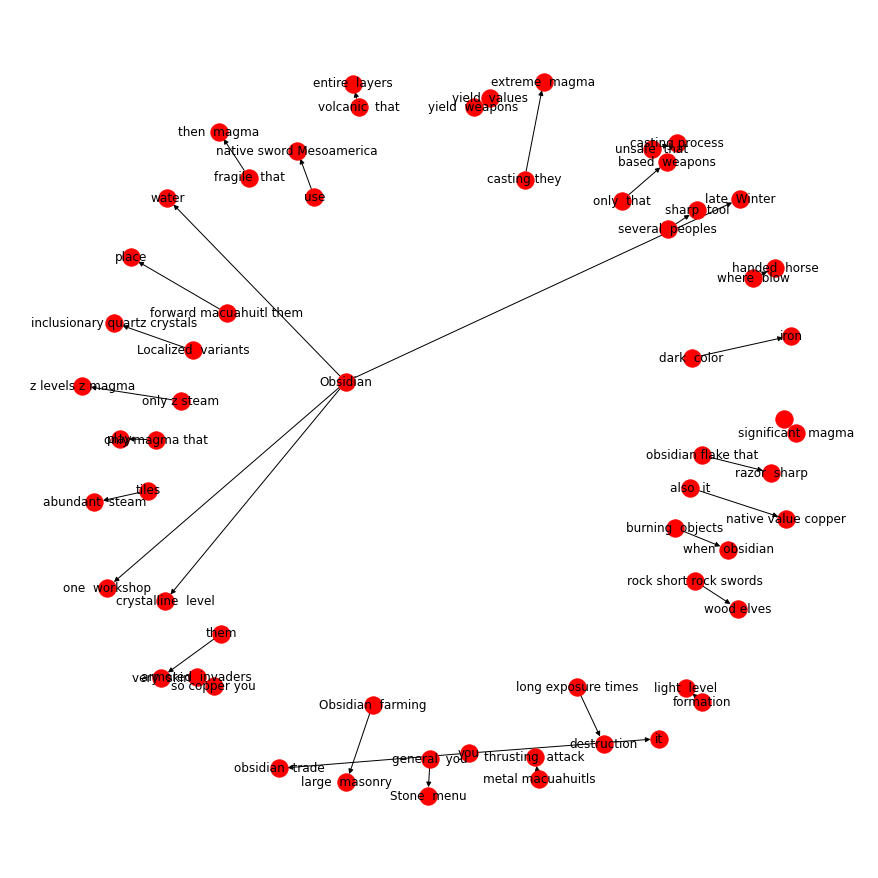

In [38]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='red', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Well, this is not exactly what we were hoping for (still looks quite a sight though!).

It turns out that we have created a graph with all the relations that we had. It becomes really hard to visualize a graph with these many relations or predicates.

So, it’s advisable to use only a few important relations to visualize a graph. I will take one relation at a time. Let’s start with the relation “composed by”:

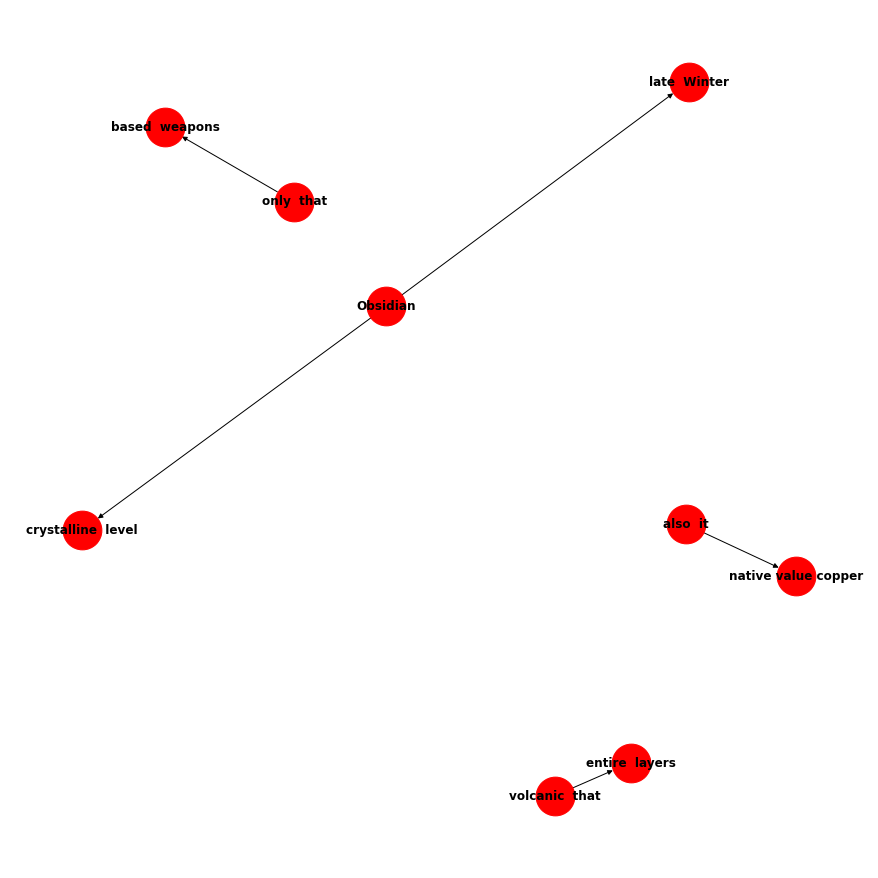

In [39]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="is"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos, font_weight='bold')
plt.show()

Since writing is an important role in any movie, I would like to visualize the graph for the “written by” relation:



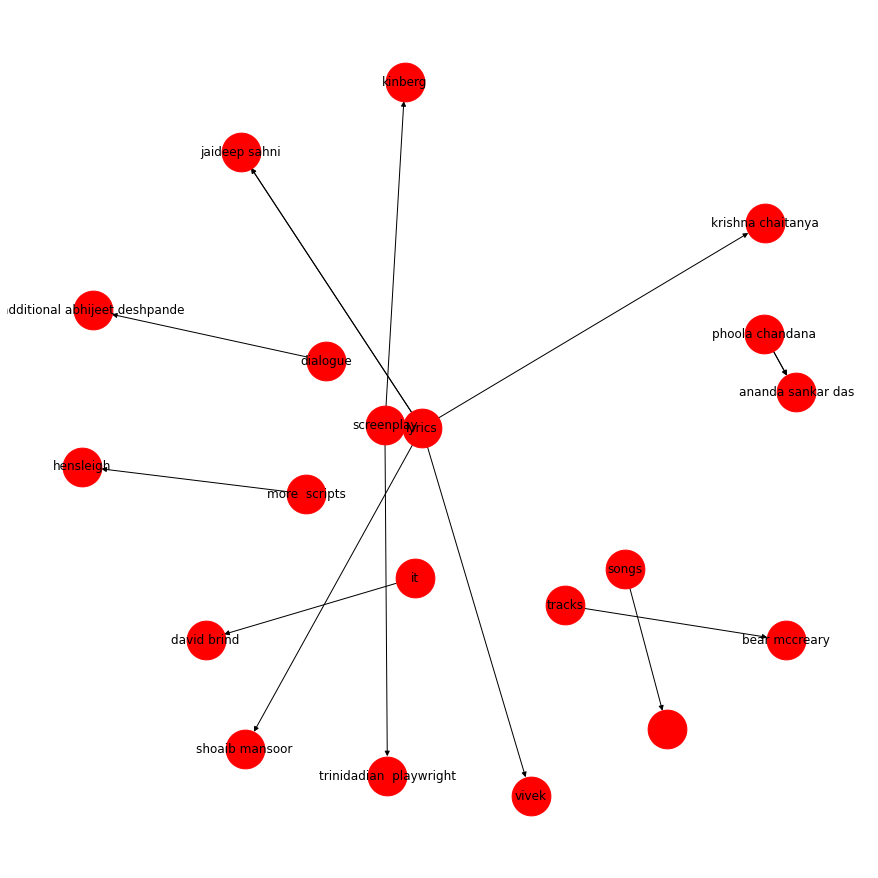

In [29]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Let’s see the knowledge graph of another important predicate, i.e., the “released in”:



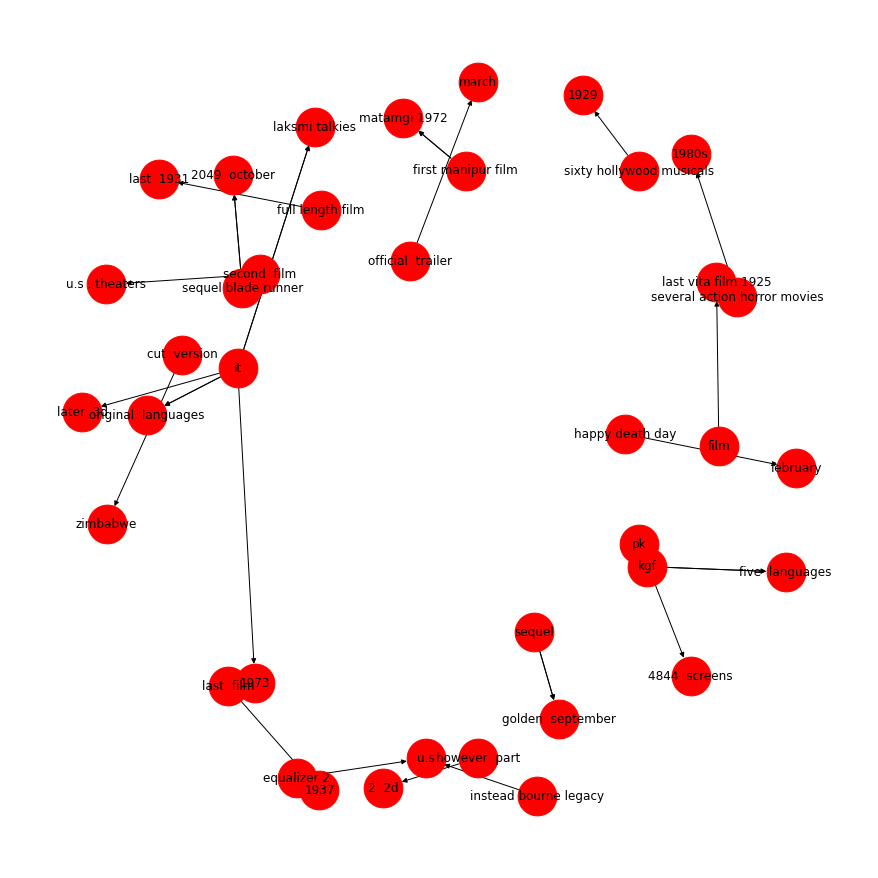

In [30]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()